<a href="https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/bulk/notebooks/general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bulk RNA-seq (with differential transcript expression)

Notebook authored by Delaney K. Sullivan.

Please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

* Bray NL, Pimentel H, Melsted P, Pachter, L. Near-optimal probabilistic RNA-seq quantification. Nat biotechnol., 2016;34(5):525-527.

* Sullivan DK, Min KH (Joseph), Hjörleifsson KE, Luebbert L, Holley G, Moses L, et al. kallisto, bustools, and kb-python for quantifying bulk, single-cell, and single-nucleus RNA-seq. Nat Protoc. 2025;20:587–607.





## Install kb-python

In [1]:
!pip install kb_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.8-py3-none-any.whl size=54012 sha256=8ecdd255dc8928c091b369b81fefc150a84b5cfd88f83c0e6359fa2371d8f709
  Stored in directory: /root/.cache/pip/wheels/0a/65/00/30ea772562c1e326e9a076e6a526216abc6c5456852cc2

## Download datasets

Differential analysis of gene regulation at transcript resolution with RNA-seq by Cole Trapnell, David G Henderickson, Martin Savageau, Loyal Goff, John L Rinn and Lior Pachter, Nature Biotechnology 31, 46–53 (2013).

The control (C) and knockdown (KD) fibroblast samples were subsetted to 1 million reads each.

### Control (n=3)

In [2]:
!wget -q https://github.com/pachterlab/data/releases/download/v1/C_1_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/C_1_R2.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/C_2_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/C_2_R2.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/C_3_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/C_3_R2.fastq.gz


### Knockdown (n=3)

In [3]:
!wget -q https://github.com/pachterlab/data/releases/download/v1/KD_1_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/KD_1_R2.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/KD_2_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/KD_2_R2.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/KD_3_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/KD_3_R2.fastq.gz

## Download kallisto human index

In [4]:
!kb ref -d human -i human_index.idx -g human_t2g.txt

[2025-06-19 02:40:51,007]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100% 138M/138M [00:01<00:00, 134MB/s]
[2025-06-19 02:40:52,095]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz


## Map reads to index

Below, we quantify RNA-seq reads using kallisto (via `kb count`) with bootstrapping (via `--bootstraps`) to obtain estimates of quantification uncertainty. Here, we set the number of bootstraps to 10.

For the input to `kb count`, we supply all FASTQ files on the command-line (and the order in which the files are supplied determines the sample identities after read quantification).

Alternately, we could have created a batch.txt file containing the following:

```
Control_1   C_1_R1.fastq.gz  C_1_R2.fastq.gz
Control_2   C_2_R1.fastq.gz  C_2_R2.fastq.gz
Control_3   C_3_R1.fastq.gz  C_3_R2.fastq.gz
Knockdown_1 KD_1_R1.fastq.gz KD_1_R2.fastq.gz
Knockdown_2 KD_2_R1.fastq.gz KD_2_R2.fastq.gz
Knockdown_3 KD_3_R1.fastq.gz KD_3_R2.fastq.gz
```


And then supply that batch.txt file directly to the command in lieu of the individual FASTQ files.

In [5]:
!kb count -x BULK -i human_index.idx -g human_t2g.txt --parity=paired --tcc --matrix-to-directories -o output_dir \
--bootstraps=5 -t 2 --overwrite --verbose \
C_1_R1.fastq.gz C_1_R2.fastq.gz C_2_R1.fastq.gz C_2_R2.fastq.gz C_3_R1.fastq.gz C_3_R2.fastq.gz \
KD_1_R1.fastq.gz KD_1_R2.fastq.gz KD_2_R1.fastq.gz KD_2_R2.fastq.gz KD_3_R1.fastq.gz KD_3_R2.fastq.gz

[2025-06-19 02:41:28,558]   DEBUG [main] Printing verbose output
[2025-06-19 02:41:30,761]   DEBUG [main] kallisto binary located at /usr/local/lib/python3.11/dist-packages/kb_python/bins/linux/kallisto/kallisto
[2025-06-19 02:41:30,761]   DEBUG [main] bustools binary located at /usr/local/lib/python3.11/dist-packages/kb_python/bins/linux/bustools/bustools
[2025-06-19 02:41:30,761]   DEBUG [main] Creating `output_dir/tmp` directory
[2025-06-19 02:41:30,762]   DEBUG [main] Namespace(list=False, command='count', tmp=None, keep_tmp=False, verbose=True, i='human_index.idx', g='human_t2g.txt', x='BULK', o='output_dir', num=False, w=None, exact_barcodes=False, r=None, t=2, m='2G', strand=None, inleaved=False, genomebam=False, aa=False, gtf=None, chromosomes=None, workflow='standard', em=False, mm=False, tcc=True, filter=None, filter_threshold=None, c1=None, c2=None, overwrite=True, dry_run=False, batch_barcodes=False, loom=False, h5ad=False, loom_names='barcode,target_name', sum='none', cell

### Now inspect the output

There are several "abundance" directories that contain our quantifications. The numbers correspond to the order with which we supplied the FASTQ files to the `kb count` command (i.e. abundance_1, abundance_2, and abundance_3 are the control samples and abundance_4, abundance_5, and abundance_6 are the knockdown samples)

In [6]:
!ls output_dir/quant_unfiltered

abundance_1  abundance_6		    matrix.abundance.tpm.mtx
abundance_2  genes.txt			    matrix.efflens.mtx
abundance_3  matrix.abundance.gene.mtx	    matrix.fld.tsv
abundance_4  matrix.abundance.gene.tpm.mtx  transcript_lengths.txt
abundance_5  matrix.abundance.mtx	    transcripts.txt


## Differential expression of transcripts

### Set up R environment and edgeR

In [7]:
%load_ext rpy2.ipython

In [8]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("edgeR", ask=FALSE, quiet=TRUE)
BiocManager::install("rhdf5", ask=FALSE, quiet=TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.26.tar.gz'
Content type 'application/x-gzip' length 594489 bytes (580 KB)
downloaded 580 KB


The downloaded source packages are in
	‘/tmp/RtmplaovhL/downloaded_packages’
'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)
Installing package(s) 'BiocVersion', 'edgeR'
also installing the dependencies ‘statmod’, ‘limma’, ‘locfit’

Old packages: 'data.table', 'evaluate'
'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)
Installing

## Use edgeR for differential transcript expression analysis

We list the paths to the abundance directories and then run edgeR on them via `catchKallisto`. See the follow publication for details on edgeR:

Chen, Y., Chen, L., Lun, A. T., Baldoni, P. L., & Smyth, G. K. (2025). edgeR v4: powerful differential analysis of sequencing data with expanded functionality and improved support for small counts and larger datasets. Nucleic Acids Research, 53(2), gkaf018.


In [9]:
%%R
require(edgeR)
paths <- c("output_dir/quant_unfiltered/abundance_1",
           "output_dir/quant_unfiltered/abundance_2",
           "output_dir/quant_unfiltered/abundance_3",
           "output_dir/quant_unfiltered/abundance_4",
           "output_dir/quant_unfiltered/abundance_5",
           "output_dir/quant_unfiltered/abundance_6")
results <- catchKallisto(paths)

Reading output_dir/quant_unfiltered/abundance_1, 227665 transcripts, 5 bootstraps
Reading output_dir/quant_unfiltered/abundance_2, 227665 transcripts, 5 bootstraps
Reading output_dir/quant_unfiltered/abundance_3, 227665 transcripts, 5 bootstraps
Reading output_dir/quant_unfiltered/abundance_4, 227665 transcripts, 5 bootstraps
Reading output_dir/quant_unfiltered/abundance_5, 227665 transcripts, 5 bootstraps
Reading output_dir/quant_unfiltered/abundance_6, 227665 transcripts, 5 bootstraps


Loading required package: edgeR
Loading required package: limma


In [10]:
%%R
print(results$counts[1:5,,drop=F])
print(length(results$annotation$Overdispersion))

                  output_dir/quant_unfiltered/abundance_1
ENST00000308647.8                               18.119158
ENST00000378736.3                                0.000000
ENST00000472194.6                                3.606886
ENST00000474481.1                                1.487577
ENST00000485748.5                                1.878091
                  output_dir/quant_unfiltered/abundance_2
ENST00000308647.8                              16.3508487
ENST00000378736.3                               0.4174387
ENST00000472194.6                               2.6497518
ENST00000474481.1                               0.0000000
ENST00000485748.5                               0.0000000
                  output_dir/quant_unfiltered/abundance_3
ENST00000308647.8                               17.676045
ENST00000378736.3                                2.851005
ENST00000472194.6                                0.000000
ENST00000474481.1                                0.000000
ENST0000048574

In [11]:
%%R
samples <- c("Control_1", "Control_2", "Control_3", "Knockdown_1", "Knockdown_2", "Knockdown_3")
group <- c("C", "C", "C", "K", "K", "K") # C = control; K = knockdown

In [12]:
%%R
colnames(results$counts) <- samples
cts.scaled <- results$counts/results$annotation$Overdispersion
dge.scaled <- DGEList(counts = cts.scaled, group=group)

In [13]:
%%R
keep <- filterByExpr(dge.scaled)
dge.scaled.filtr <- dge.scaled[keep, , keep.lib.sizes = FALSE]
dge.scaled.filtr <- calcNormFactors(dge.scaled.filtr)

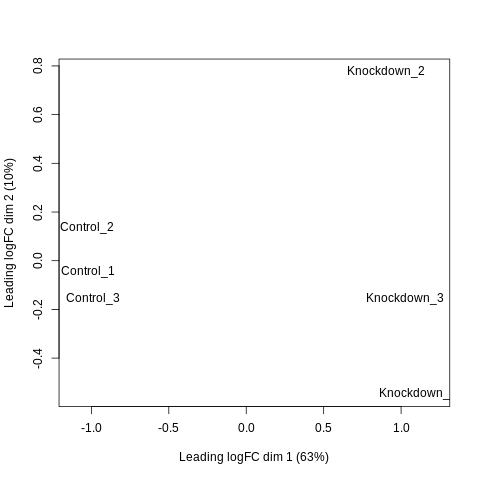

In [14]:
%%R
plotMDS(dge.scaled.filtr)

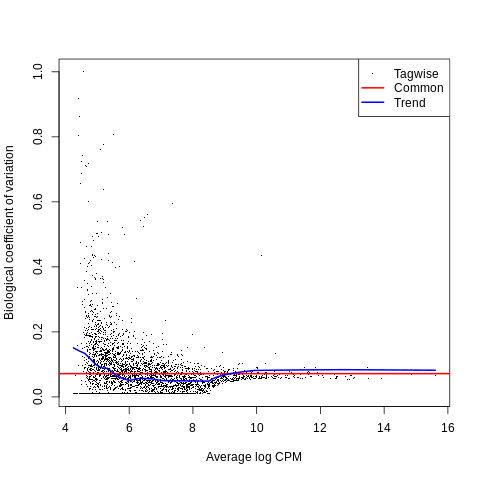

In [15]:
%%R
design <- model.matrix(~group-1,data = dge.scaled.filtr$samples)
colnames(design) <- gsub('group','',colnames(design))
dge.scaled.filtr <- estimateDisp(dge.scaled.filtr,design)
plotBCV(dge.scaled.filtr)

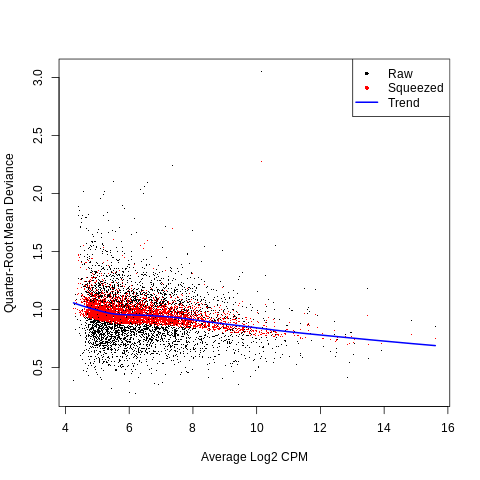

In [16]:
%%R
fit <- glmQLFit(dge.scaled.filtr,design)
plotQLDisp(fit)

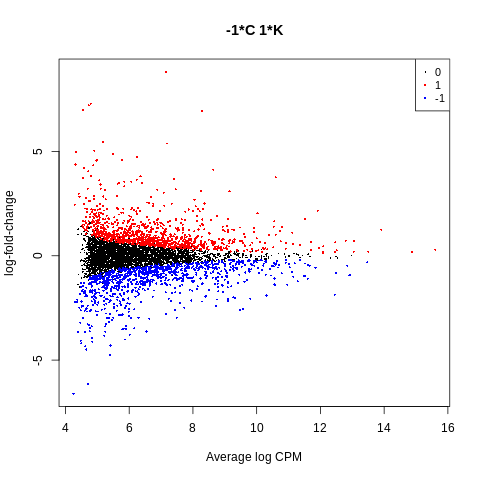

In [17]:
%%R
qlf <- glmQLFTest(fit, contrast = makeContrasts(K-C, levels = design))
tt <- topTags(qlf,n = Inf)
is.de <- decideTests(qlf)
plotMD(qlf, status = is.de, values = c(1, -1), col = c("red","blue"), legend = "topright", cex=0.4)

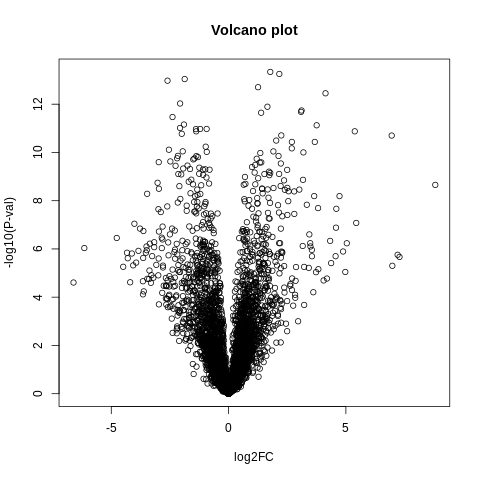

In [18]:
%%R
plot(qlf$table$logFC, -1*log10(qlf$table$PValue), main="Volcano plot", xlab="log2FC", ylab="-log10(P-val)")

In [19]:
%%R
head(qlf$table)

                          logFC   logCPM            F    PValue
ENST00000356607.9  -0.001899721 5.303589 0.0000167155 0.9968000
ENST00000328089.11  0.321175658 5.765121 1.8001385388 0.2026674
ENST00000375592.8  -0.041597613 5.700996 0.0332228001 0.8581821
ENST00000346436.11  0.453813269 4.743627 1.0396290301 0.3265557
ENST00000378512.5  -0.513499461 4.907051 1.4394727424 0.2516714
ENST00000443438.5  -0.109194711 5.451238 0.0663814381 0.8007152
